## Tutorial 07 - Non linear Elliptic problem
**_Keywords: DEIM, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider a non linear elliptic problem in a two-dimensional spatial domain $\Omega=(0,1)^2$. We impose a homogeneous Dirichlet condition on the boundary $\partial\Omega$. The source term is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = 100\sin(2\pi x_0)cos(2\pi x_1) \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

This problem is characterized by two parameters. The first parameter $\mu_0$ controls the strength of the sink term and the second parameter $\mu_1$ the strength of the nonlinearity. The range of the two parameters is the following:
$$
\mu_0,\mu_1\in[0.01,10.0]
$$
The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.01,10]^2.
$$


In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method. In order to preserve the affinity assumption the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.



### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The strong formulation of the parametrized problem is given by:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that</center>

$$ -\nabla^2u(\boldsymbol{\mu})+\frac{\mu_0}{\mu_1}(\exp\{\mu_1u(\boldsymbol{\mu})\}-1)=g(\boldsymbol{x}; \boldsymbol{\mu})$$
<br>
    
The corresponding weak formulation reads:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)+c\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H_1(\Omega) : v|_{\partial\Omega}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized bilinear form $c(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v;\boldsymbol{\mu})=\mu_0\int_{\Omega} \frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \int_{\Omega}g(\boldsymbol{x}; \boldsymbol{\mu})v \ d\boldsymbol{x}.$$

The output of interest $s(\boldsymbol{\mu})$ is given by
$$s(\boldsymbol{\mu}) = \int_{\Omega} v \ d\boldsymbol{x}$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import sys
sys.path.append("../../MLniCS/")


from mlnics import NN, Losses, Normalization
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)},$$
$$c(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{c}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x}}_{c_0(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{100}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}\sin(2\pi x_0)cos(2\pi x_1)v \ d\boldsymbol{x}}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class NonlinearElliptic(NonlinearEllipticProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$, $\Theta^{c}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $a_*(u, v)$, $c_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class NonlinearElliptic(NonlinearEllipticProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearEllipticProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        self.u = self._solution
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Store the forcing term expression
        self.f = Expression("sin(2*pi*x[0])*sin(2*pi*x[1])", element=self.V.ufl_element())
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NonlinearEllipticDEIM"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.
            return (theta_a0,)
        elif term == "c":
            theta_c0 = mu[0]
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 100.
            return (theta_f0,)
        elif term == "s":
            theta_s0 = 1.0
            return (theta_s0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            du = self.du
            a0 = inner(grad(du), grad(v)) * dx
            return (a0,)
        elif term == "c":
            u = self.u
            mu = self.mu
            c0 = (exp(mu[1] * u) - 1) / mu[1] * v * dx
            return (c0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "s":
            s0 = v * dx
            return (s0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            du = self.du
            x0 = inner(grad(du), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearEllipticProblem)
def CustomizeReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
    class ReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearElliptic_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNonlinearElliptic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the NonlinearElliptic class

In [5]:
problem = NonlinearElliptic(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.01, 10.0), (0.01, 10.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20, DEIM=21)
reduction_method.set_tolerance(1e-8, DEIM=1e-4)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(50, DEIM=60)
reduced_problem = reduction_method.offline()

In [8]:
reduction_method.initialize_testing_set(50, DEIM=60)
net = NN.RONN(problem, reduction_method)

In [9]:
input_normalization = Normalization.IdentityNormalization()
output_normalization = Normalization.IdentityNormalization()

In [10]:
pdnn_loss = Losses.PDNN_Loss(net, output_normalization)
pinn_loss = Losses.PINN_Loss(net)
prnn_loss = Losses.PRNN_Loss(net, output_normalization, omega=1.)

In [12]:
NN.train(net, pinn_loss, input_normalization, lr=0.00001, epochs=10000)

Beginning training...
0 0.01247579787638544 	mean error(validation) = 0.023286467000186627
100 0.010527717626691952 	mean error(validation) = 0.020741027702968484
200 0.008950408626521434 	mean error(validation) = 0.01870227137173838
300 0.007635899685390895 	mean error(validation) = 0.01688005522375352
400 0.006524588297759946 	mean error(validation) = 0.015220238910031412
500 0.005580476941016602 	mean error(validation) = 0.013845283580268816
600 0.004778824738444345 	mean error(validation) = 0.012637481495766248
700 0.0040998048670518525 	mean error(validation) = 0.011499037998086081
800 0.0035258454019231715 	mean error(validation) = 0.010432566153467222
900 0.0030409497728224833 	mean error(validation) = 0.009447329436702841
1000 0.002630864493761276 	mean error(validation) = 0.008550665910842612
1100 0.002282945240662024 	mean error(validation) = 0.00774310761678554
1200 0.0019864834939711078 	mean error(validation) = 0.007021425908707965
1300 0.001732504903600258 	mean error(val

### 4.6. Perform an online solve

0:  |F(x)| = 2.45182; step 0.527297
1:  |F(x)| = 0.318169; step 1
2:  |F(x)| = 0.0160489; step 1
3:  |F(x)| = 3.48124e-05; step 1
4:  |F(x)| = 8.48606e-07; step 1
scipy solver converged in 6 iterations.
[-4.87926159e+00 -2.50593109e-01 -6.15314679e-03  2.32357490e-02
  2.68071439e-03 -1.38134974e-03  2.92614919e-04 -1.20002673e-04]


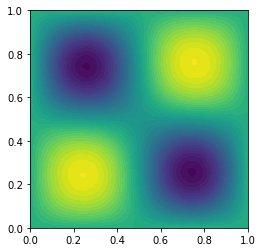

In [13]:
online_mu = (5., 5.)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
print(reduced_problem._solution)
plot(reduced_solution, reduced_problem=reduced_problem)

[-4.88098907e+00 -2.48682544e-01 -5.89742884e-03  2.33993530e-02
  2.67504621e-03 -1.49981026e-03  5.90898097e-04  9.33073461e-05]


RONN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=8, bias=True)
  )
)

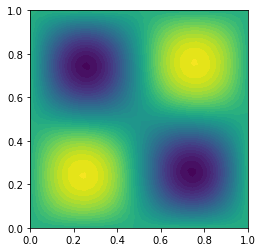

In [14]:
net.eval()

with torch.no_grad():
    online_mu_nn = torch.tensor(online_mu)
    # NOTE: Change output_normalization accordingly for the different losses
    reduced_solution_nn = net.solve(online_mu_nn, input_normalization, output_normalization=None)
    print(reduced_solution_nn)
    plot(reduced_solution_nn, reduced_problem=reduced_problem)

net.train()

0.0007977956404628542


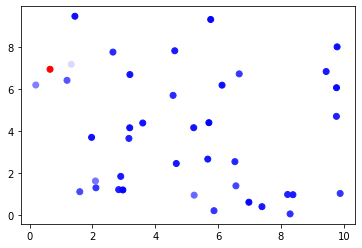

In [15]:
mu, errors, error_plot = NN.plot_error(net, input_normalization)
print(np.mean(errors))
error_plot

In [16]:
problem.set_mu(online_mu)
problem.solve()
hf_sol = np.array(problem._solution.vector())
rb_sol = np.array((reduced_problem.basis_functions * reduced_solution).vector())
nn_sol = np.array((reduced_problem.basis_functions * reduced_solution_nn).vector())
print(np.mean((hf_sol - rb_sol)**2), np.mean((rb_sol - nn_sol)**2), np.mean((hf_sol - nn_sol)**2))

3.443592217047621e-10 1.3367480360835813e-07 1.3530682990360842e-07


### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(50, DEIM=60)
reduction_method.error_analysis()

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()